# 笔记


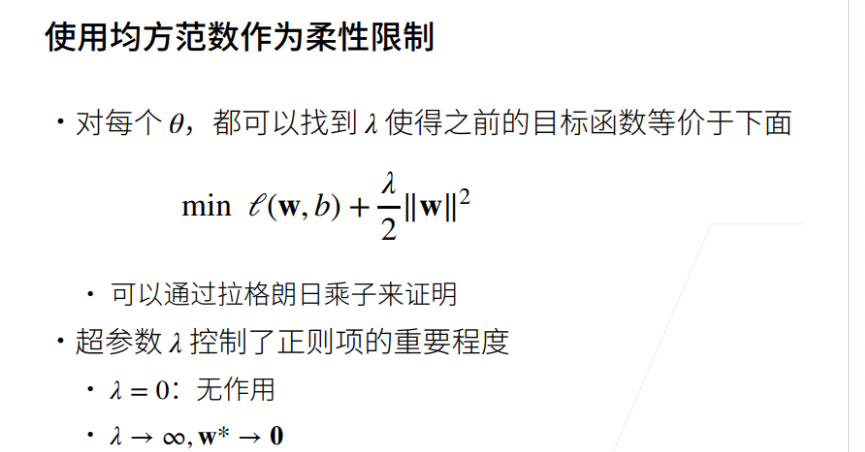


- 拉格朗日乘子法原本是用于解决约束条件下的多元函数极值问题。举例，求f(x,y)的最小值，但是有约束C(x,y) = 0。乘子法给的一般思路是，构造一个新的函数g(x,y,λ) = f(x,y) +λC(x,y)，当同时满足g'x = g'y = 0时，函数取到最小值。这件结论的几何含义是，当f(x,y)与C(x,y)的等高线相切时，取到最小值。
- L2 正则化：通过在模型的损失函数中增加权重的 L2 范数（<font color=red>权重向量的平方和</font>）来实现正则化。L2 正则化会使权重值变得较小，但不会直接导致权重稀疏，因此不具有特征选择的作用，但可以有效地控制模型的复杂度。

L2范数会导致权重衰退:

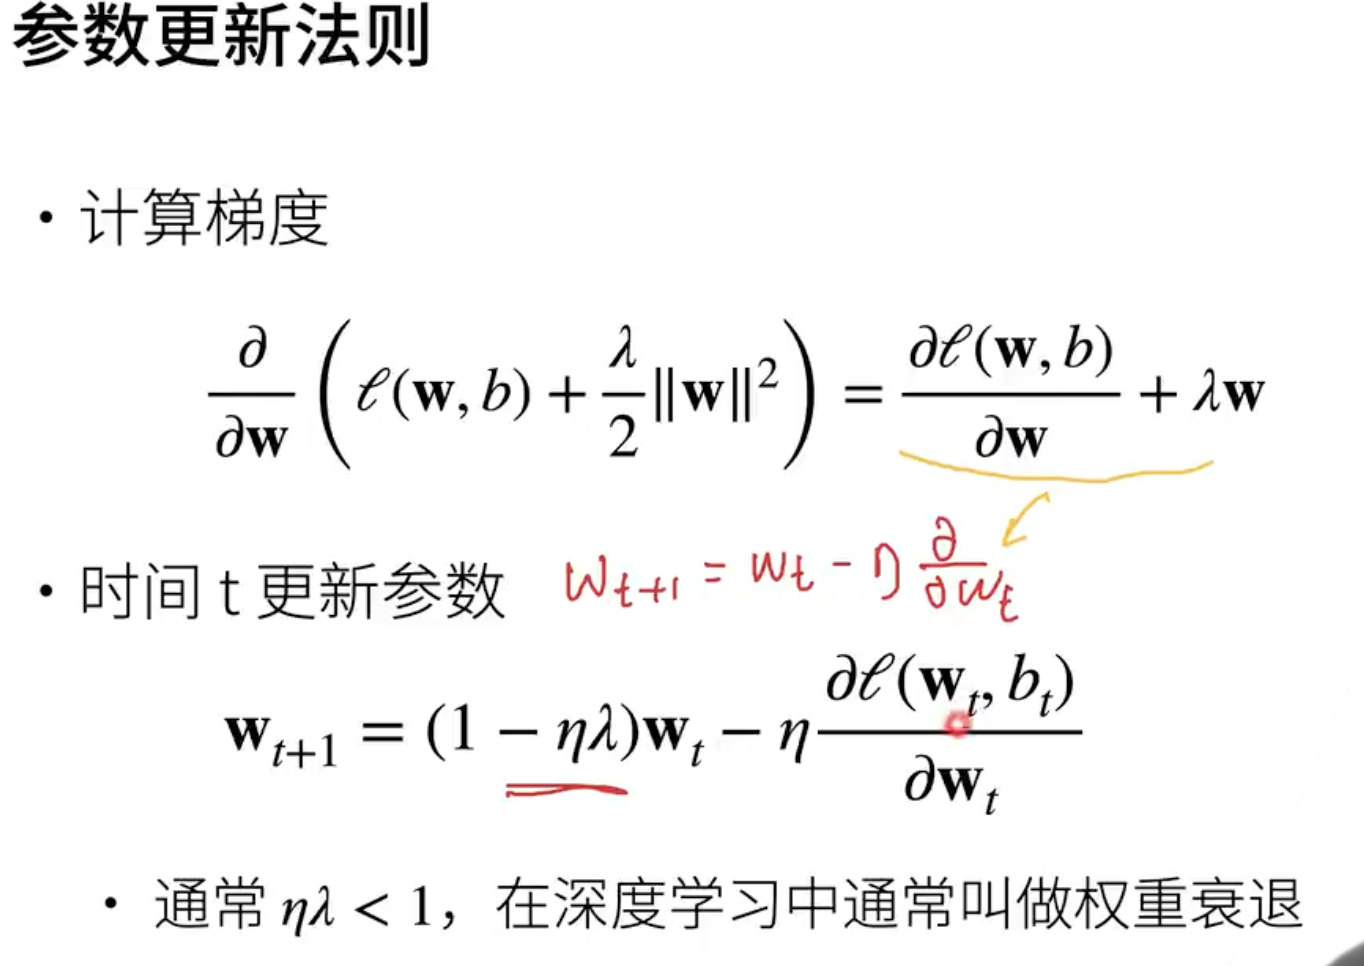

总结： 
- 权重衰退通过L2正则项使得模型参数不会过大，从而控制
模型复杂度
- 正则项权重是控制模型复杂度的超参数

# 代码

In [18]:
%matplotlib inline
import torch
from torch import nn
from d2l import torch as d2l

n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * 0.01, 0.05
# d2l.synthetic_data:Generate y = Xw + b + noise.(x是正态分布的随机数)
train_data = d2l.synthetic_data(true_w, true_b, n_train)
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [19]:
# 简洁实现
def train_concise(wd): # wd权重衰退系数,用于控制权重相关惩罚项的强度
    net = nn.Sequential(nn.Linear(num_inputs,1))
    [param.data.normal_ for param in net.parameters()]
    loss = nn.MSELoss(reduction='none')
    num_epochs, lr = 100, 0.003
    #随机梯度下降SGD，可设置权重衰退
    ## 这里传的是一个列表，包含了两个字典元素，这种形式是用于更精细地控制不同参数组的优化设置，
    trainer = torch.optim.SGD(
    [{"params":net[0].weight,'weight_decay':wd},
     {"params":net[0].bias}],
    lr=lr)
    animator = d2l.Animator(xlabel='epochs', ylabel='loss', yscale='log',
                            xlim=[5, num_epochs], legend=['train', 'test'])
    for epoch in range(num_epochs):
        for X,y in train_iter:
            trainer.zero_grad()
            l = loss(net(X),y)
            l.mean().backward()
            trainer.step()
        if (epoch + 1) % 5 == 0:
            animator.add(epoch + 1,
                         (d2l.evaluate_loss(net, train_iter, loss),
                          d2l.evaluate_loss(net, test_iter, loss)))
    print('w的L2范数：', net[0].weight.norm().item())

w的L2范数： 0.5354033708572388


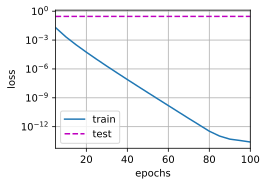

In [20]:
# 没有权重衰退：训练集小，过拟合，测试集损失不下降
train_concise(0)

w的L2范数： 0.03841288015246391


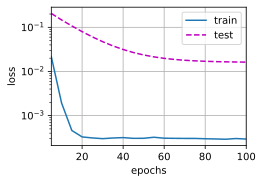

In [26]:
# 有权重衰退
train_concise(3)

总结  
- 正则化是处理过拟合的常用方法：在训练集的损失函数中加入惩罚项，以降低学习到的模型的复杂度。
- 保持模型简单的一个特别的选择是使用惩罚的权重衰减。这会导致学习算法更新步骤中的权重衰减。
- 权重衰减功能在深度学习框架的优化器中提供。

一些小细节：


1. loss.backward()在前，然后跟一个step。

In [ ]:
total_loss.backward()
optimizer_G.step()


优化器就是需要根据网络反向传播的梯度信息来**更新网络的参数**，以起到降低loss函数计算值的作用   
那么为什么optimizer.step()需要放在每一个batch训练中，而不是epoch训练中，这是因为现在的mini-batch训练模式是假定每一个训练集就只有mini-batch这样大，因此实际上可以将每一次mini-batch看做是一次训练，一次训练更新一次参数空间，因而optimizer.step()放在这里

___
2. L2范数？

范数，是具有“距离”概念的函数。我们知道距离的定义是一个宽泛的概念，只要满足非负、自反、三角不等式就可以称之为距离。范数是一种强化了的距离概念，它在定义上比距离多了一条数乘的运算法则。有时候为了便于理解，我们可以把范数当作距离来理解。  
欧氏距离就是一种L2范数，表示向量元素的平方和再开平方。
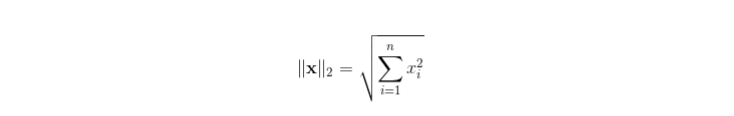